In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.models.resnet import BasicBlock
import torch.nn.functional as F
import torchvision.models as models

In [2]:
#checking for device
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
from einops import rearrange

In [5]:
class RandomGaussianNoise(nn.Module):
    def __init__(self, std_dev):
        super(RandomGaussianNoise, self).__init__()
        self.std_dev = std_dev

    def forward(self, images):
        noise = torch.randn_like(images) * self.std_dev
        noisy_images = torch.clamp(images + noise, 0, 1)
        return noisy_images

class CNNWithSelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(CNNWithSelfAttention, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(input_dim, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)
        self.projection_head = nn.Sequential(
            nn.Linear(256, 128)  # Adjusted to match the output of self-attention
        )

    def forward(self, x):
        features = self.backbone(x)
        b, c, h, w = features.size()
        # Rearrange for self-attention
        features = rearrange(features, 'b c h w -> (h w) b c')
        features = features.permute(1, 0, 2)  # (seq_len, batch, embed_dim) for self-attention
        attention_output, _ = self.attention(features, features, features)
        attention_output = attention_output.permute(1, 0, 2)  # (batch, seq_len, embed_dim)
        attention_output = rearrange(attention_output, '(h w) b c -> b (h w) c', h=h, w=w)  # Adjust rearrangement
        return self.projection_head(attention_output)


class PretextCNNWithSelfAttention(nn.Module):
    def __init__(self, input_dim, kernel_size, sigma):
        super(PretextCNNWithSelfAttention, self).__init__()
        self.gaussian_blur = RandomGaussianNoise(std_dev)
        self.cnn_with_attention = CNNWithSelfAttention(input_dim)

    def forward(self, x):
        blurred_x = self.gaussian_blur(x)
        return self.cnn_with_attention(blurred_x)

In [6]:
input_dim = 3 # Assuming RGB images
kernel_size = 3
sigma = 1.5
std_dev = 0.1

In [7]:
pretext_model = PretextCNNWithSelfAttention(input_dim, kernel_size, sigma)
pretext_model.to(device)

PretextCNNWithSelfAttention(
  (gaussian_blur): RandomGaussianNoise()
  (cnn_with_attention): CNNWithSelfAttention(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (projection_head): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
    )
  )
)

In [8]:
# Define NT-Xent loss function
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, projections_1, projections_2):
        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = F.normalize(projections_1, p=2, dim=1)
        projections_2 = F.normalize(projections_2, p=2, dim=1)
        similarities = torch.matmul(projections_1, projections_2.t()) / self.temperature

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = projections_1.size(0)
        contrastive_labels = torch.arange(batch_size, device=projections_1.device)

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = F.cross_entropy(similarities, contrastive_labels)
        loss_2_1 = F.cross_entropy(similarities.t(), contrastive_labels)

        return (loss_1_2 + loss_2_1) / 2

In [9]:
#Transforms
transform=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [10]:
optimizer=optim.SGD(pretext_model.parameters(),lr=0.1,weight_decay=0.0001)
# Define the loss function and optimizer
criterion = NTXentLoss(temperature=0.2)

In [11]:
# Define number of epochs and folds
num_epochs = 6
num_folds = 5

In [12]:
import torchvision
# Path for training directory
train_path = '/kaggle/input/ssl-png/SSL_png'
class_folders = torchvision.datasets.ImageFolder(train_path,transform=transform)
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [13]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=16, shuffle=True
    )

    # Training loop
    for epoch in range(num_epochs):
        pretext_model.train()
        running_train_loss = 0.0

        for images, _ in train_loader:
            images = images.to(device)  # Move input images to the appropriate device
            optimizer.zero_grad()

            batch_size = images.size(0)
            for i in range(batch_size):
                image = images[i].unsqueeze(0)  # Select one image from the batch
                
                projection_1 = pretext_model(image).squeeze(0)
                projection_2 = pretext_model(image).squeeze(0)
                
                loss = criterion(projection_1, projection_2)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader.dataset)

        # Validation loop
        pretext_model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for images, _ in val_loader:
                images = images.to(device)
                batch_size = images.size(0)
                for i in range(batch_size):
                    image = images[i].unsqueeze(0)  # Select one image from the batch
                    
                    projection_1 = pretext_model(image).squeeze(0)
                    projection_2 = pretext_model(image).squeeze(0)

                    loss = criterion(projection_1, projection_2)
                    running_val_loss += loss

        epoch_val_loss = running_val_loss / len(val_loader.dataset)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Fold 1/5
Epoch [1/6], Train Loss: 4.0266, Validation Loss: 3.8778
Epoch [2/6], Train Loss: 3.8659, Validation Loss: 3.9113
Epoch [3/6], Train Loss: 3.8051, Validation Loss: 3.6213
Epoch [4/6], Train Loss: 3.5491, Validation Loss: 3.4709
Epoch [5/6], Train Loss: 3.4427, Validation Loss: 3.3904
Epoch [6/6], Train Loss: 3.2816, Validation Loss: 3.2503
Fold 2/5
Epoch [1/6], Train Loss: 3.2008, Validation Loss: 3.1570
Epoch [2/6], Train Loss: 3.1394, Validation Loss: 3.1098
Epoch [3/6], Train Loss: 3.1001, Validation Loss: 3.0802
Epoch [4/6], Train Loss: 3.0280, Validation Loss: 3.0361
Epoch [5/6], Train Loss: 3.0042, Validation Loss: 3.0006
Epoch [6/6], Train Loss: 3.0087, Validation Loss: 2.9652
Fold 3/5
Epoch [1/6], Train Loss: 2.9257, Validation Loss: 2.9097
Epoch [2/6], Train Loss: 2.8903, Validation Loss: 2.8735
Epoch [3/6], Train Loss: 2.8720, Validation Loss: 2.8389
Epoch [4/6], Train Loss: 2.8576, Validation Loss: 2.8659
Epoch [5/6], Train Loss: 2.8190, Validation Loss: 2.7971
Epoc

# Fine Tuning 

In [14]:
class FineTunedModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(FineTunedModel, self).__init__()
        self.backbone = CNNWithSelfAttention(input_dim)
        self.backbone.fc = nn.Identity()
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)
        # Freeze the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Replace the projection head with classification layers
        self.classifier = nn.Sequential(
            nn.Linear(256, 64),  # Adjusted to match the output of the projection head
            nn.ReLU(inplace=True),
            nn.Linear(64, num_classes)  # Adjusted to output num_classes directly
        )

    def forward(self, x):
        with torch.no_grad():
            features = self.backbone.backbone(x)  # Extract features using backbone
        b, c, h, w = features.size()
        # Rearrange for self-attention
        features = rearrange(features, 'b c h w -> (h w) b c')
        features = features.permute(1, 0, 2)  # (seq_len, batch, embed_dim) for self-attention
        attention_output, _ = self.attention(features, features, features)
        attention_output = attention_output.permute(1, 0, 2)  # (batch, seq_len, embed_dim)
        attention_output = rearrange(attention_output, '(h w) b c -> b (h w) c', h=h, w=w)  # Adjust rearrangement
        return self.classifier(attention_output).mean(1)  # Average pooling over sequence dimension

In [15]:
# Instantiate the fine-tuned model
fine_tuned_model = FineTunedModel(input_dim=input_dim, num_classes=2)
fine_tuned_model.to(device)

FineTunedModel(
  (backbone): CNNWithSelfAttention(
    (backbone): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (projection_head): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
    )
    (fc): Identity()
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicall

In [17]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [18]:
from torchsummary import summary
summary(fine_tuned_model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
         MaxPool2d-3           [-1, 64, 75, 75]               0
            Conv2d-4          [-1, 128, 75, 75]          73,856
              ReLU-5          [-1, 128, 75, 75]               0
         MaxPool2d-6          [-1, 128, 37, 37]               0
            Conv2d-7          [-1, 256, 37, 37]         295,168
              ReLU-8          [-1, 256, 37, 37]               0
         MaxPool2d-9          [-1, 256, 18, 18]               0
MultiheadAttention-10  [[-1, 324, 256], [-1, 2, 2]]               0
           Linear-11              [-1, 324, 64]          16,448
             ReLU-12              [-1, 324, 64]               0
           Linear-13               [-1, 324, 2]             130
Total params: 387,394
Trainable par

In [19]:
optimizer=optim.Adam(fine_tuned_model.parameters(),lr=0.01,weight_decay=0.0001)
# Define BCE loss function
loss_function = nn.CrossEntropyLoss()

In [20]:
# Initialize best accuracy
best_accuracy = 0.0

# Initialize KFold object
kf = KFold(n_splits=num_folds, shuffle=True)

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(class_folders)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    dataset_train = Subset(class_folders, train_index)
    dataset_valid = Subset(class_folders, val_index)

    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=32, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset_valid, batch_size=16, shuffle=True
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Set model to training mode
        fine_tuned_model.train()
        
        train_accuracy = 0.0
        train_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = fine_tuned_model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            train_accuracy += int(torch.sum(prediction == labels.data))
        
        train_accuracy = train_accuracy / len(train_index)
        train_loss = train_loss / len(train_index)
        
        # Validation loop
        fine_tuned_model.eval()
        
        val_accuracy = 0.0
        val_loss = 0.0
        
        for i, (images, labels) in enumerate(val_loader):
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()
            
            outputs = fine_tuned_model(images)
            loss = F.cross_entropy(outputs, labels)
            val_loss += loss.item()* images.size(0)  # Accumulate the loss
            _, prediction = torch.max(outputs.data, 1)
            val_accuracy += int(torch.sum(prediction == labels.data))
            
        # Compute average loss and accuracy
        val_loss /= len(val_index)
        val_accuracy = val_accuracy / len(val_index)
        
        # Step the scheduler
        # scheduler.step()
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.3f}, Train Accuracy: {train_accuracy:.3f}, Val Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.3f}")
        
#         # Save the best model
#         if val_accuracy > best_accuracy:
#             torch.save(fine_tuned_model.state_dict(), 'best_model.pth')
#             best_accuracy = val_accuracy
            
# print(f"Best Validation Accuracy: {best_accuracy}")

Fold 1/5
Epoch [1/6], Train Loss: 0.874, Train Accuracy: 0.541, Val Loss: 0.773, Validation Accuracy: 0.581
Epoch [2/6], Train Loss: 0.635, Train Accuracy: 0.738, Val Loss: 0.681, Validation Accuracy: 0.581
Epoch [3/6], Train Loss: 0.627, Train Accuracy: 0.738, Val Loss: 0.686, Validation Accuracy: 0.581
Epoch [4/6], Train Loss: 0.597, Train Accuracy: 0.738, Val Loss: 1.811, Validation Accuracy: 0.581
Epoch [5/6], Train Loss: 0.748, Train Accuracy: 0.738, Val Loss: 0.945, Validation Accuracy: 0.581
Epoch [6/6], Train Loss: 0.644, Train Accuracy: 0.738, Val Loss: 0.684, Validation Accuracy: 0.581
Fold 2/5
Epoch [1/6], Train Loss: 0.632, Train Accuracy: 0.709, Val Loss: 0.617, Validation Accuracy: 0.698
Epoch [2/6], Train Loss: 0.614, Train Accuracy: 0.709, Val Loss: 0.646, Validation Accuracy: 0.698
Epoch [3/6], Train Loss: 0.651, Train Accuracy: 0.709, Val Loss: 0.613, Validation Accuracy: 0.698
Epoch [4/6], Train Loss: 0.614, Train Accuracy: 0.709, Val Loss: 0.659, Validation Accuracy

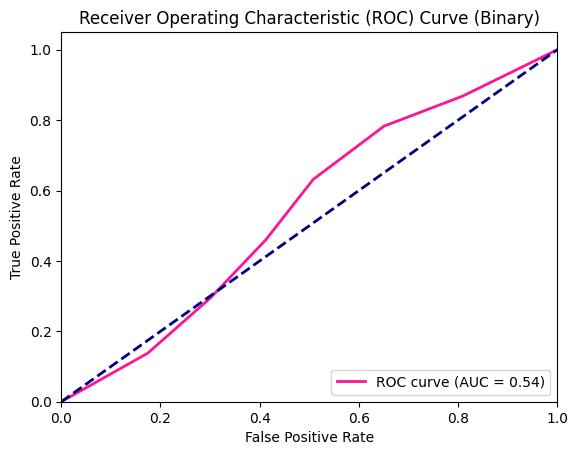

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Define the test dataset path and transformation
test_path = '/kaggle/input/ssl-png/SSL_png'
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transform),
    batch_size=32, shuffle=True
)
# Assuming model and test_loader are defined

# Evaluate model
fine_tuned_model.eval()

y_score_list = []
y_true_list = []

for images, labels in test_loader:
    if torch.cuda.is_available():
        images = images.cuda()
        labels = labels.cuda()

    with torch.no_grad():
        y_score_batch = fine_tuned_model(images)
    
    y_score_list.append(y_score_batch.cpu().numpy())
    y_true_list.append(labels.cpu().numpy())

y_score = np.vstack(y_score_list)
y_true = np.hstack(y_true_list)

# Binarize the ground truth labels
y_true_bin = label_binarize(y_true, classes=np.unique(y_true))

# Compute ROC curve and AUC for class 1
fpr, tpr, _ = roc_curve(y_true_bin, y_score[:, 1])
roc_auc = roc_auc_score(y_true_bin, y_score[:, 1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='deeppink', lw=2, label=f'ROC curve (AUC = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Binary)')
plt.legend(loc='lower right')
plt.show()